# MELLIN TRANSFORM FROM DISCRETE DATA

Shannon's theorem says that it is possible to reconstruct a function $f(t)$ in time with $t \in \mathbb{R}$ from a discrete sampling of the type $f(na)$, $n \in \mathbb{N}$ if the Fourier transform of the function has support only in the first Bruillen zone, i.e. $[-\tfrac{\pi}{a}, \tfrac{\pi}{a}]$. If we now consider the correlation function of a Quantum Field Theory in Euclidean time and finite volume, it is the sum of exponentials, so its Fourier trunsform has not a finite support and this creates discretization errors in if we try to reconstruct $f(t)$ from discrete data. 

#### Definitions

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
from scipy.integrate import quad, quad_vec
from scipy.special import expi, sinc, gamma, gammainc
mp.mp.dps = 100

plt.style.use('my_style.mplstyle')

def ft_exp_cont(k:float | list | np.ndarray, w0:float) -> float:
    return 2 * w0 /(w0 ** 2.0 + k ** 2.0)

def ft_exp_discr(k:float | list | np.ndarray, w0:float, a:float, t_max:int) -> float:
    n_max = int(t_max/a)
    points = np.reshape(a * np.arange(1, n_max + 1), (n_max, 1))
    l = 1
    if isinstance(k, (list, np.ndarray)):
        l = len(k)
    k_vect = np.reshape(np.array(k), (l, 1))
    return a + 2*a * np.sum(np.tile(np.exp(-w0 * points), (1, l)) * np.cos(points @ k_vect.T), 0)

def ift_exp(t:float | np.ndarray, w0:float, a:float, num:bool = False):
    if num:
        return 2*quad_vec(lambda x: ft_exp_cont(x, w0)*np.cos(x*t)/(2*np.pi), 0, np.pi/a)[0]
    else:
        return ((1.0j*(expi(t*complex(w0, -np.pi/a)) - expi(t*(complex(w0, np.pi/a)))) +\
      np.exp(2*t*w0)*(2*np.pi + 1.0j*(expi(t*complex(-w0, np.pi/a)) - expi(t*complex(-w0, -np.pi/a)))))*np.exp(-t*w0)/(2*np.pi)).real

def ift_exp_discr(t:float | list | np.ndarray, w0:float, a:float, t_max:int):
    n_max = int(t_max/a)
    l = 1
    if isinstance(t, (list, np.ndarray)):
        l = len(t)
    points = np.tile(np.reshape(np.arange(-n_max, n_max+1), (1, 2*n_max + 1)), (l, 1))
    return np.sum(np.exp(-w0 * np.abs(points * a)) * sinc(np.tile(np.reshape(t, (l, 1)), 2*n_max+1)/a - points), 1)

def ft_exp_discr_mp(k:float | list | np.ndarray, w0:float, a:float, t_max:int) -> float:
    n_max = int(t_max/a)
    sum = 0
    for i in mp.arange(1, n_max+1):
        sum += mp.exp(-w0 * a * i) * mp.cos(k * a * i)
    
    return a * (1 + 2*sum)

def mel(s:float, t_max:float, w0:float, a:float, t_max_ft:int):
    n_max = int(t_max_ft/a)
    if t_max != np.inf:
        f = lambda x: ft_exp_discr_mp(x, w0, a, n_max) * mp.hyp1f2(0.5*complex(0.5, s), 0.5, 0.5*complex(2.5, s), -(x*t_max)**2.0/4)
        return mp.quad(f, [0, mp.pi/a]) * t_max ** complex(0.5, s) * 2 / (mp.pi * complex(1, s))
    else:
        #f = lambda x: ft_exp_discr_mp(x, w0, a, n_max) / mp.mpf(x) ** mp.mpc(0.5, s)
        #return mp.gamma(mp.mpc(0.5, s)) * mp.cos(mp.pi*mp.mpc(0.5, s)/2) * mp.quad(f, [0, mp.pi/a])/mp.pi
        sum = 0
        for i in range(1, n_max +1):
            sum += np.exp(-w0 * a * i) * complex(mp.hyp1f2(0.5*complex(0.5, -s), 0.5, 0.5*complex(2.5, -s), -(i*np.pi)**2.0/4))
        return np.abs(gamma(complex(0.5, s))*np.cos(np.pi*complex(0.5, s)/2)* (a/np.pi)**complex(0.5, s)/complex(0.5, -s) * (1+2*sum))


## Discrete Fourier transform

### Direct transform

We will perform these studies using as a model the function $C(t) = e^{-\omega_0 t}$. We begin by studying the Discrete Fourier transform with respect to the one in the continuum and then the inverse operation, to understand the discretization errors on the reconstruction of the function itself.

First of all, we extend the function to be an even function of $t$, so that the Fourier transform becomes:
$$ \mathcal{F}[C](k) = \int_{-\infty}^{+\infty}dt\,C(t) e^{-ikt} \quad\longrightarrow\quad \mathcal{F}[C](k) = 2\int_0^{+\infty}dt\,C(t)\cos(kt). $$
In the case of the C(t) above, we have:
$$ \mathcal{F}[C](k) = \frac{2w_0}{w_0^2 + k^2}. $$

The Discrete Fourier transform, instead, is:
$$ \mathcal{F}[\bar{C}](k)  = a \sum_{n=-\infty}^{+\infty} \bar{C}(na) e^{ikna} \quad\longrightarrow\quad \mathcal{F}[\bar{C}](k) = a\bar{C}(0) + 2a\sum_{n = 1}^{n = +\infty} \bar{C}(na)\cos(kna). $$
We begin by studying the difference between these two expression.

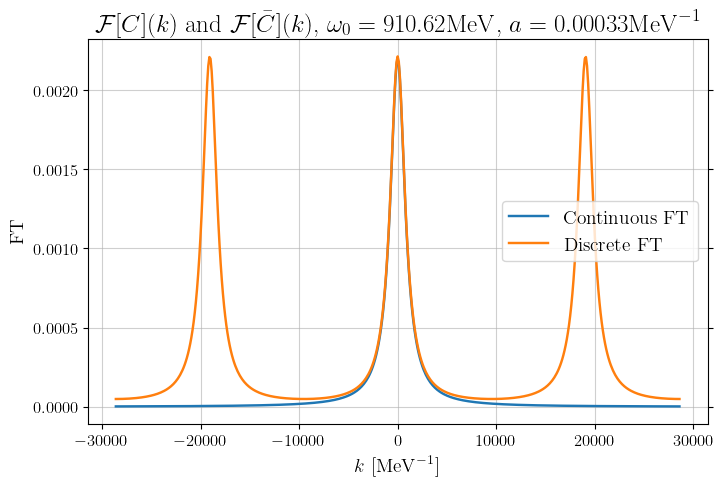

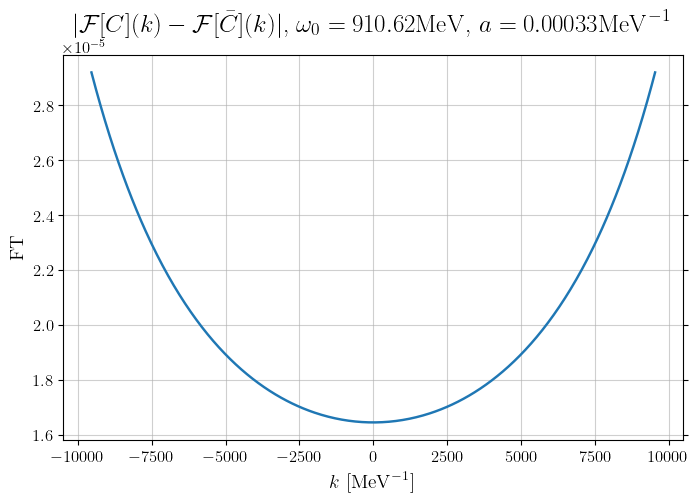

In [55]:
a = 0.065/197.3
w0 = 0.3/a
t_max = 10000*a

k = np.linspace(-3*np.pi/a, 3*np.pi/a, 501)
plt.plot(k, ft_exp_cont(k, w0), label = "Continuous FT")
plt.plot(k, ft_exp_discr(k, w0, a, t_max), label = "Discrete FT")
plt.legend()
plt.xlabel(r"$k$ $[\mathrm{MeV}^{-1}]$")
plt.ylabel(r"FT")
plt.title(r"$\mathcal{F}[C](k)$ and $\mathcal{F}[\bar{C}](k)$, " + r"$\omega_0 = {:.2f}$".format(w0) + r"$\mathrm{MeV}$, " + r"$a = {:.5f}$".format(a) + r"$\mathrm{MeV}^{-1}$")
plt.show()

k = np.linspace(-np.pi/a, np.pi/a, 501)
plt.plot(k, np.abs(ft_exp_cont(k, w0) - ft_exp_discr(k, w0, a, t_max)))
plt.xlabel(r"$k$ $[\mathrm{MeV}^{-1}]$")
plt.ylabel(r"FT")
plt.title(r"$\vert\mathcal{F}[C](k)-\mathcal{F}[\bar{C}](k)\vert$, "+r"$\omega_0 = {:.2f}$".format(w0) + r"$\mathrm{MeV}$, " + r"$a = {:.5f}$".format(a) + r"$\mathrm{MeV}^{-1}$")
plt.show()

### Inverse transform

Now we study the inverse Fourier transform of a single exponential and its discrete version. Firstly, we start from the same expression of the FT of the single exponential in the continuum and we study the truncation of the integral in the inverse transform. Then we try to combine the direct and inverse transform. In the continuum we obtain again $C(t)$, we would like to understand what happens on the lattice.

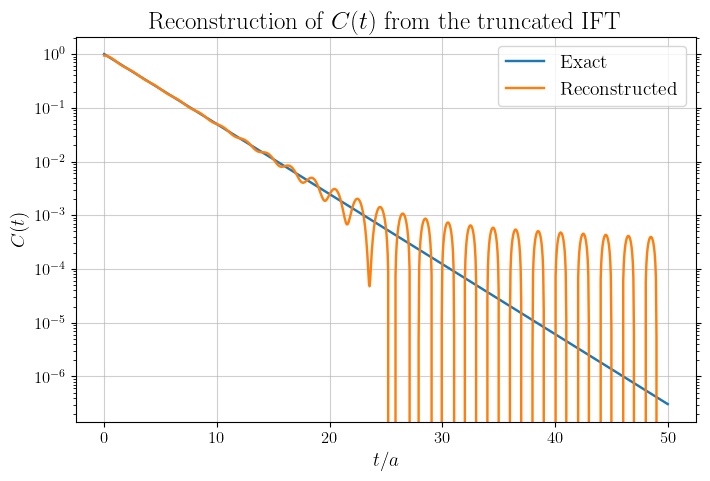

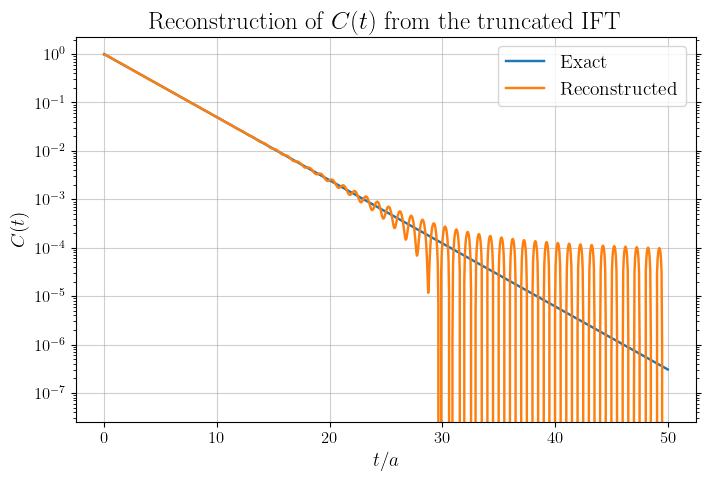

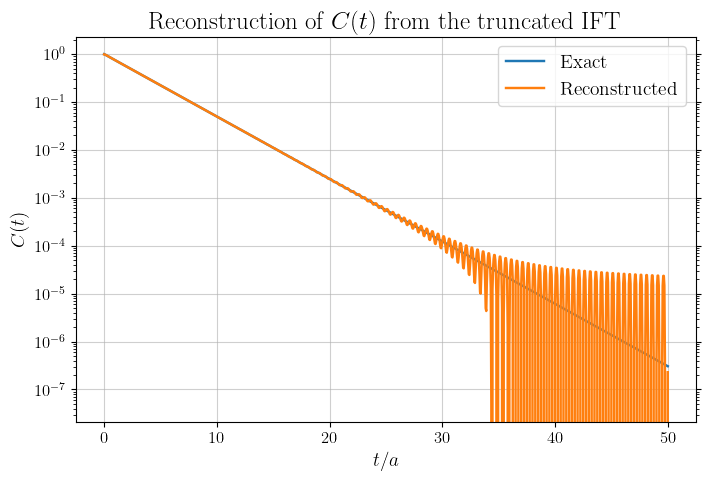

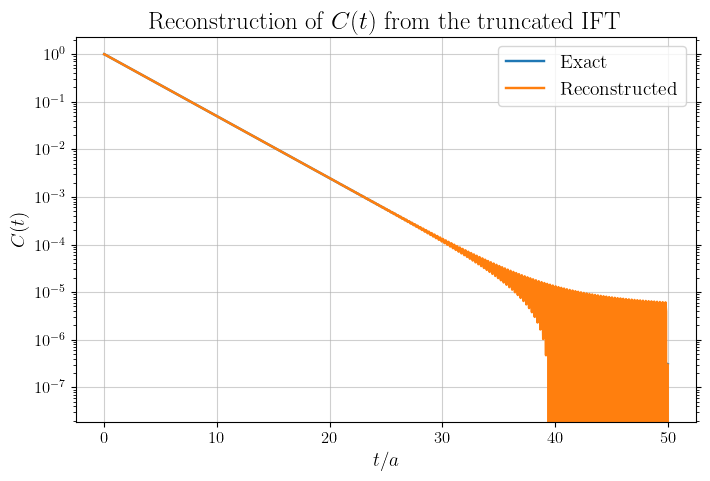

In [56]:
a = 1
w0 = 0.3/a
t = np.linspace(0.00001, 50, 1001)*a

lp = [1, 0.5, 0.25, 0.125]
for lpi in lp:
    plt.plot(t/a, np.exp(-t*w0), label = "Exact")
    plt.plot(t/a, ift_exp(t, w0, a*lpi), label = "Reconstructed")
    #plt.plot(np.arange(1, 26), np.exp(-w0 * np.arange(1, 26)*a), "o", markersize = 4, label = "Lattice points")
    plt.legend()
    plt.semilogy()
    plt.xlabel(r"$t/a$")
    plt.ylabel(r"$C(t)$")
    plt.title(r"Reconstruction of $C(t)$ from the truncated IFT")
    plt.show()

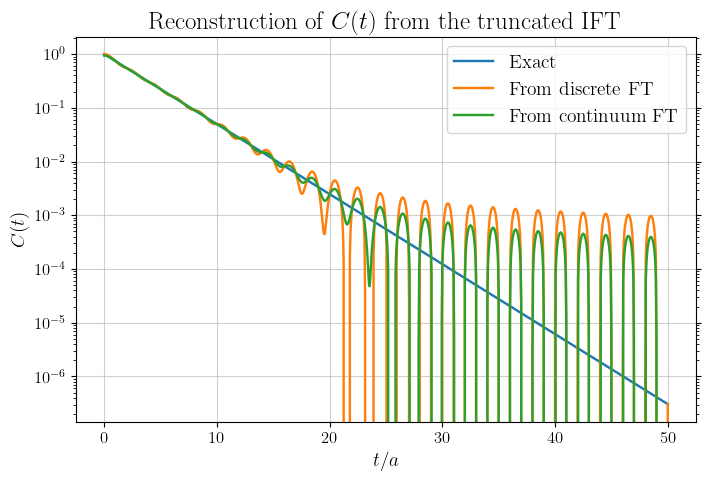

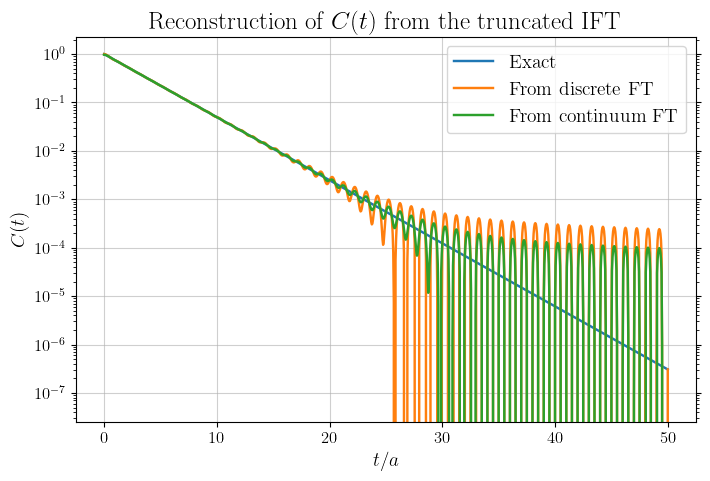

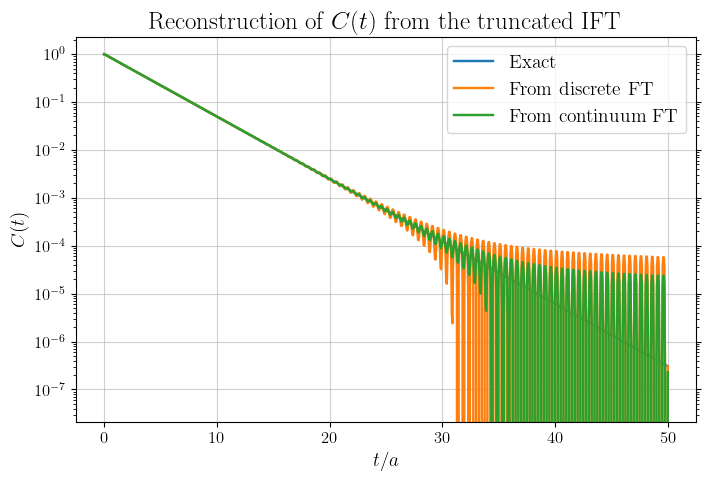

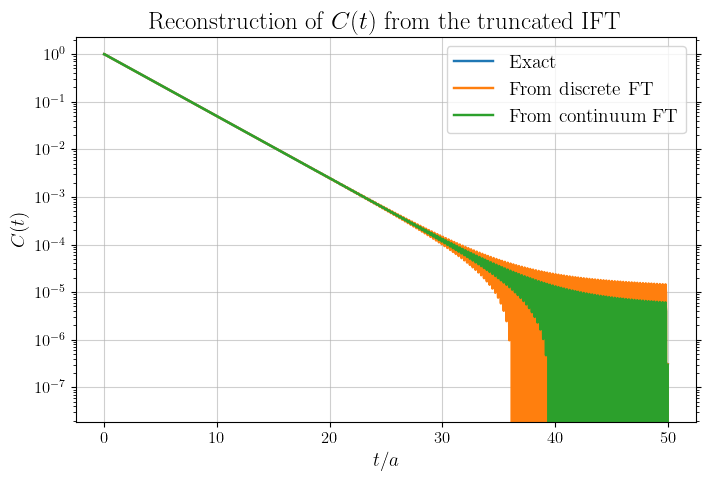

In [57]:
a = 1
w0 = 0.3/a
t = np.linspace(0.00001, 50, 1001)*a
t_max = 10000*a

lp = [1, 0.5, 0.25, 0.125]
for lpi in lp:
    plt.plot(t/a, np.exp(-t*w0), label = "Exact")
    plt.plot(t/a, ift_exp_discr(t, w0, a*lpi, t_max), label = "From discrete FT")
    plt.plot(t/a, ift_exp(t, w0, a*lpi), label = "From continuum FT")
    #plt.plot(np.arange(1, 26), np.exp(-w0 * np.arange(1, 26)*a), "o", markersize = 4, label = "Lattice points")
    plt.legend()
    plt.semilogy()
    plt.xlabel(r"$t/a$")
    plt.ylabel(r"$C(t)$")
    plt.title(r"Reconstruction of $C(t)$ from the truncated IFT")
    plt.show()


## The Mellin transform

In [149]:
a = [1, 0.5, 0.25, 0.125]
w0 = 0.3
s = np.linspace(0, 25, 51)
t_max_corr = 500
t_max = np.inf

mel_cont = np.zeros(len(s))
mel_discr = np.zeros((len(a), len(s)))
for ai in range(len(a)):
    for si in range(len(s)):
        mel_discr[ai, si] = np.abs(mel(s[si], t_max, w0, a[ai], t_max_corr))
        mel_cont[si] = np.abs(gamma(complex(0.5, s[si])) * w0**complex(-0.5, -s[si]))

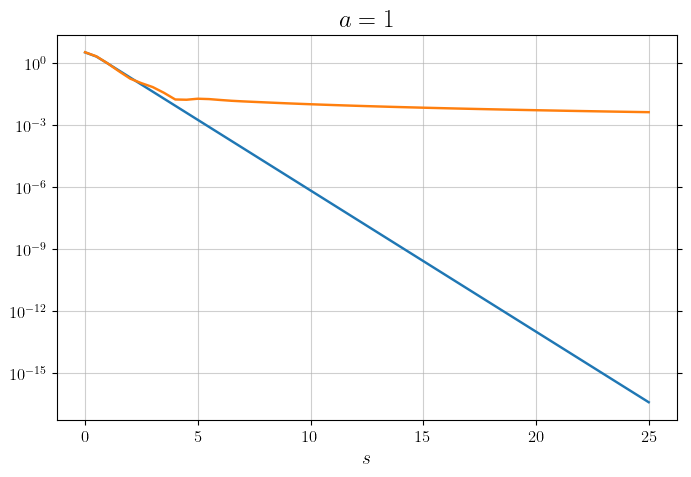

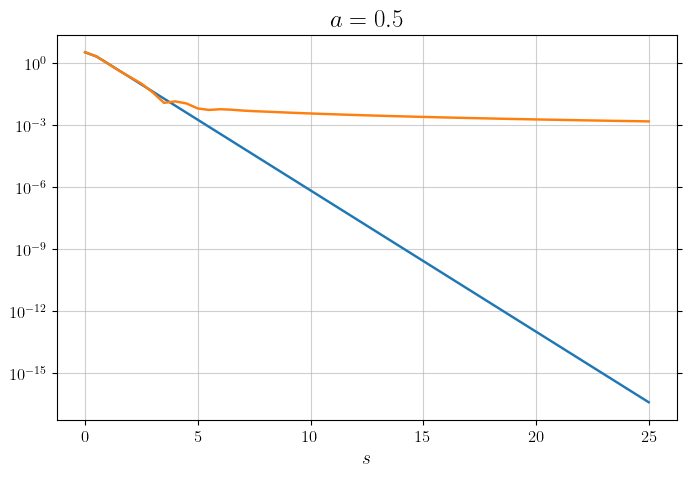

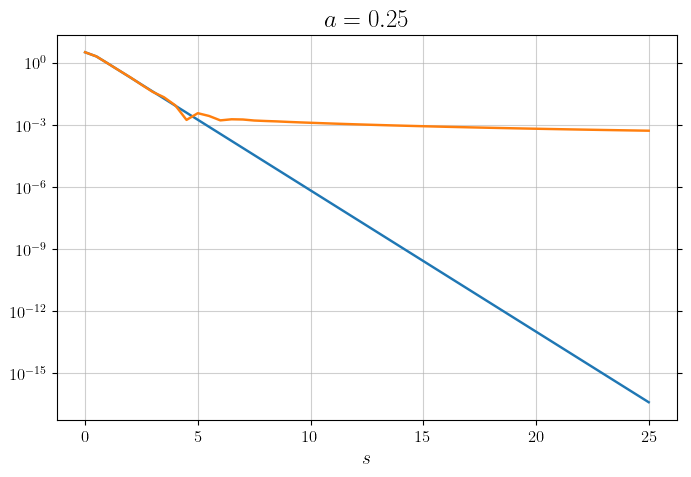

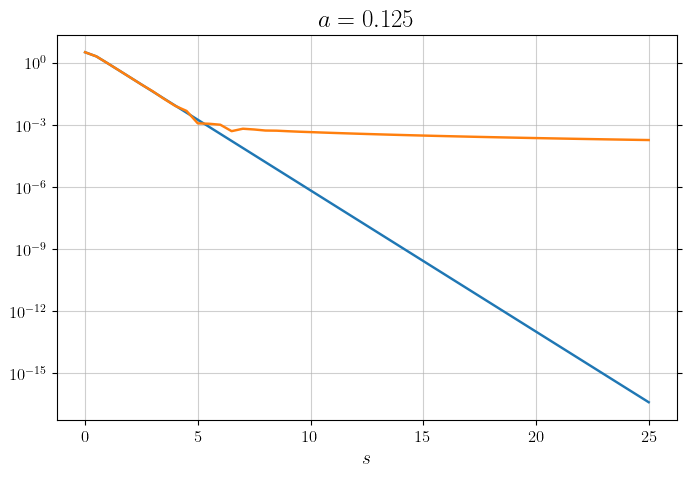

In [150]:
for ai in range(len(a)):
    plt.plot(s, mel_cont, label = "Mellin Trasform")
    plt.plot(s, mel_discr[ai], label = "Discrete Mellin transform")
    plt.xlabel(r"$s$")
    plt.title(r"$a = {}$".format(a[ai]))
    plt.semilogy()
    plt.show()

## Finite $n_\mathrm{max}$

In a real scenario we would have a finite lattice pacing and a finite temporal extent, that allows us to compute the Fourier transform only using those time slices. We begin by studying the Fourier transform, and then we will move to the reconstruction of the function itself.

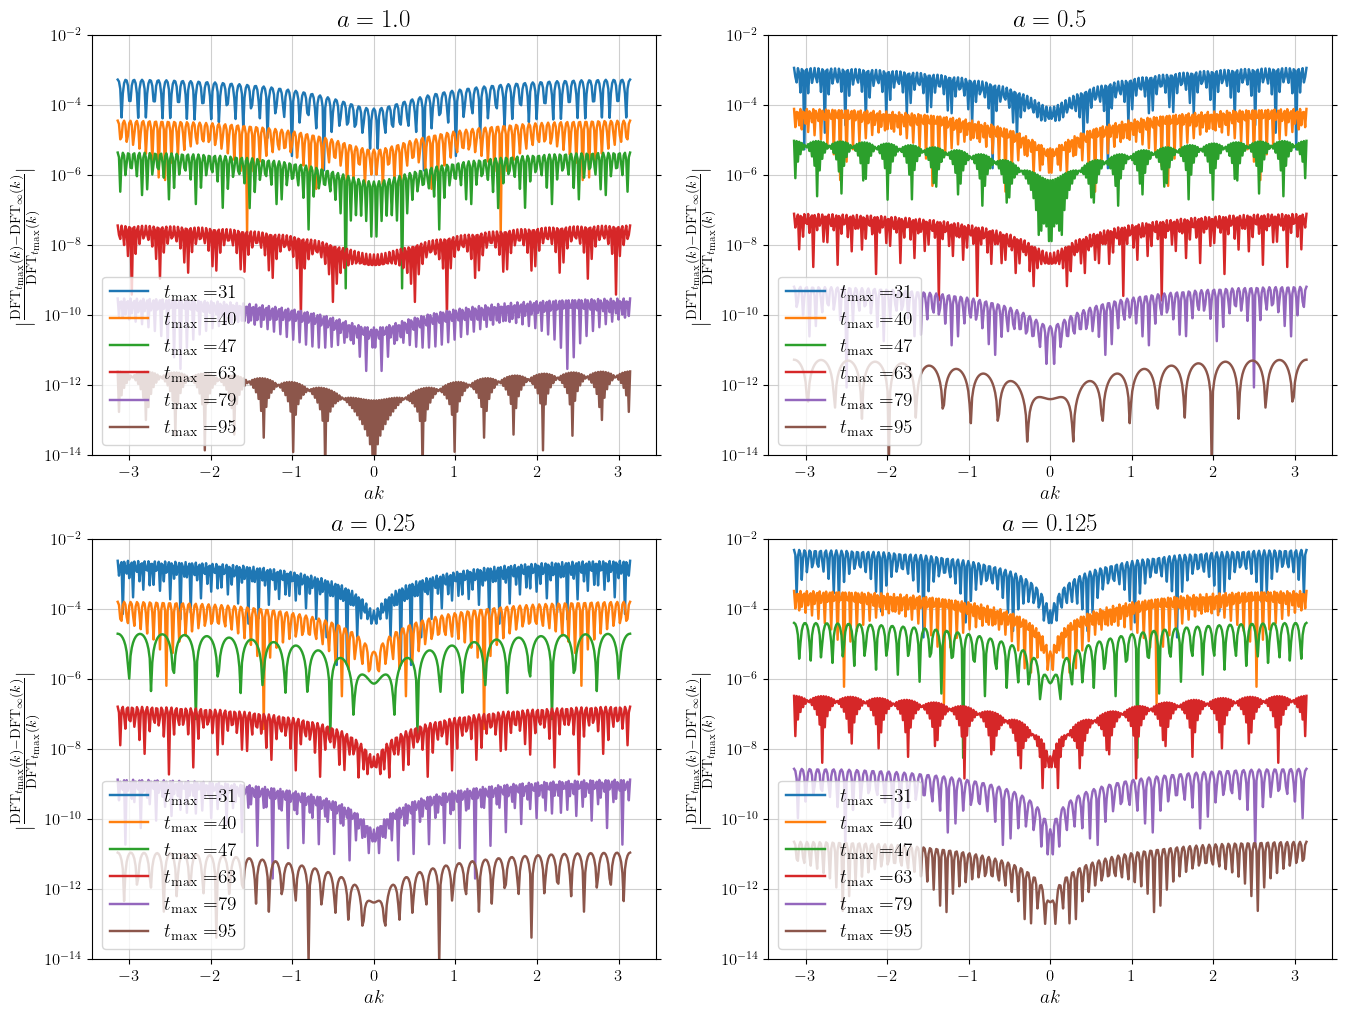

In [74]:
a = np.array([1, 0.5, 0.25, 0.125])
w0 = 0.3
t_max = np.array([31, 40, 47, 63, 79, 95])

plt.figure(figsize=[16, 12])
for ai in range(len(a)):
    plt.subplot(2, 2, ai+1)
    k = np.linspace(-np.pi/a[ai], np.pi/a[ai], 401)
    for ti in range(len(t_max)):
        plt.plot(k*a[ai], np.abs(ft_exp_discr(k, w0, a[ai], t_max[ti]) - ft_exp_discr(k, w0, a[ai], 10000))/ft_exp_discr(k, w0, a[ai], t_max[ti]), label = r"$t_\mathrm{max} = $" + r"{}".format(t_max[ti]))
    plt.legend()
    plt.semilogy()
    plt.ylim([1e-14, 1e-2])
    plt.xlabel(r"$ak$")
    plt.ylabel(r"$\vert \frac{\mathrm{DFT}_{t_\mathrm{max}}(k) - \mathrm{DFT}_{\infty}(k)}{\mathrm{DFT}_{t_\mathrm{max}}(k)} \vert$")
    plt.title(r"$a = {}$".format(a[ai]))

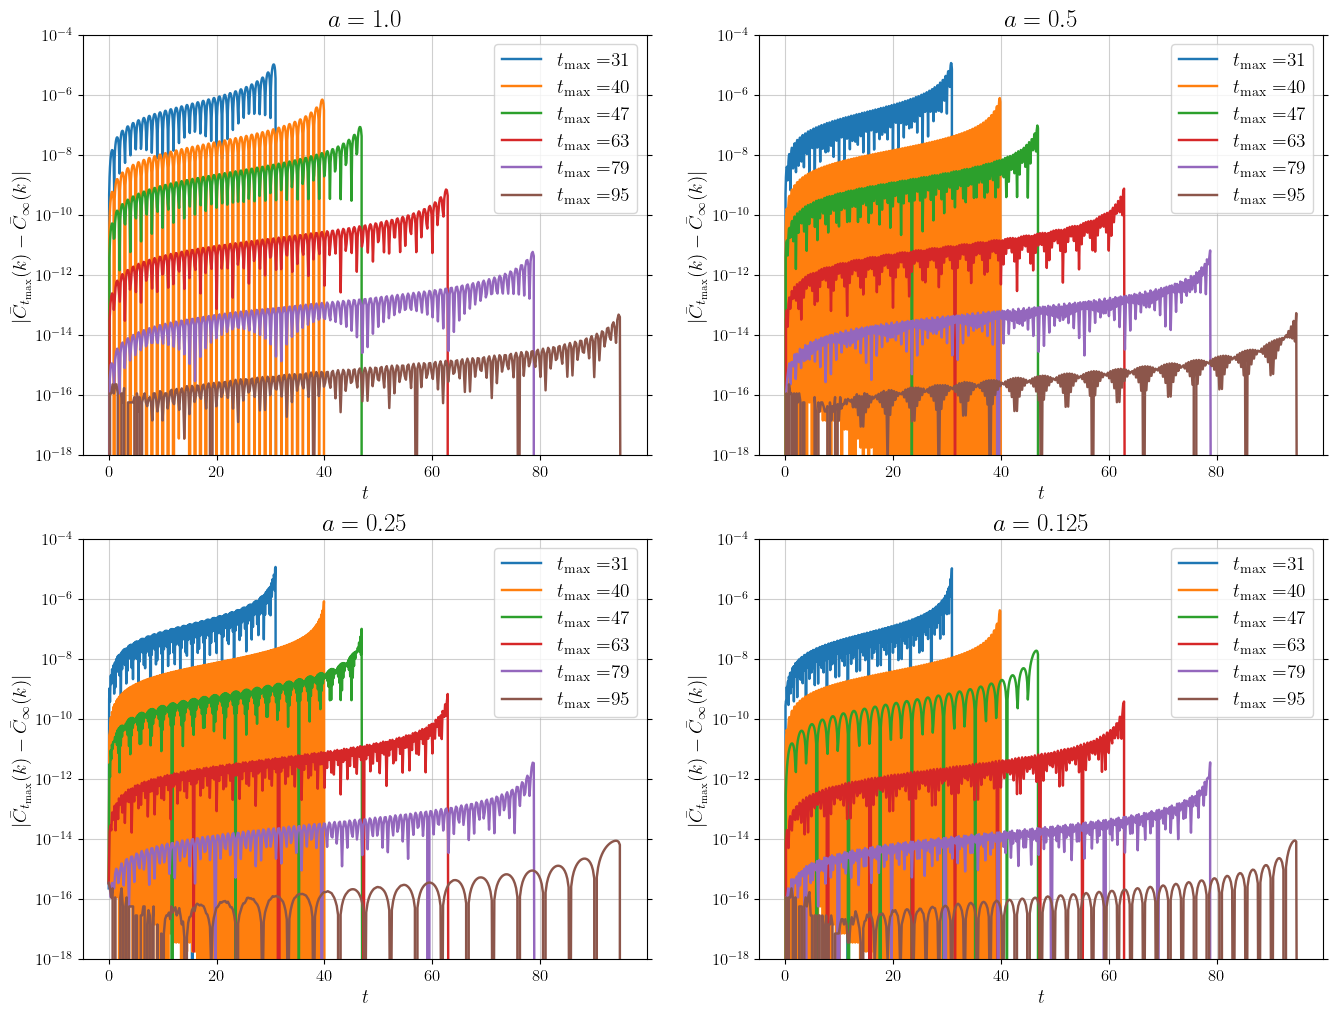

In [85]:
a = np.array([1, 0.5, 0.25, 0.125])
w0 = 0.3
t_max = np.array([31, 40, 47, 63, 79, 95])

plt.figure(figsize=[16, 12])
for ai in range(len(a)):
    plt.subplot(2, 2, ai+1)
    for ti in range(len(t_max)):
        t = np.linspace(0, t_max[ti], 401)
        plt.plot(t, np.abs(ift_exp_discr(t, w0, a[ai], t_max[ti]) - ift_exp_discr(t, w0, a[ai], 10000)), label = r"$t_\mathrm{max} = $" + r"{}".format(t_max[ti]))
    plt.legend()
    plt.semilogy()
    plt.ylim([1e-18, 1e-4])
    plt.xlabel(r"$t$")
    plt.ylabel(r"$\vert \bar{C}_{t_\mathrm{max}}(k) - \bar{C}_{\infty}(k) \vert$")
    plt.title(r"$a = {}$".format(a[ai]))

In [121]:
a = [1, 0.5, 0.25, 0.125]
w0 = 0.3
s = np.linspace(0, 25, 101)
t_max_corr = [5, 10, 15, 20, 25, 30]
t_max = np.inf

mel_discr = np.zeros((len(a), len(t_max_corr), len(s)))
for ai in range(len(a)):
    for ti in range(len(t_max_corr)):
        for si in range(len(s)):
            mel_discr[ai, ti, si] = np.abs(mel(s[si], t_max, w0, a[ai], t_max_corr[ti]))

In [122]:
mel_cont = np.zeros(len(s))
mel_trunc = np.zeros((len(t_max_corr), len(s)))
for si in range(len(s)):
    mel_cont[si] = np.abs(gamma(complex(0.5, s[si])) * w0**complex(-0.5, -s[si]))
    for ti in range(len(t_max_corr)):
        mel_trunc[ti, si] = np.abs(mp.gammainc(complex(0.5, s[si]), 0, w0*t_max_corr[ti]) *  w0**complex(-0.5, -s[si]))

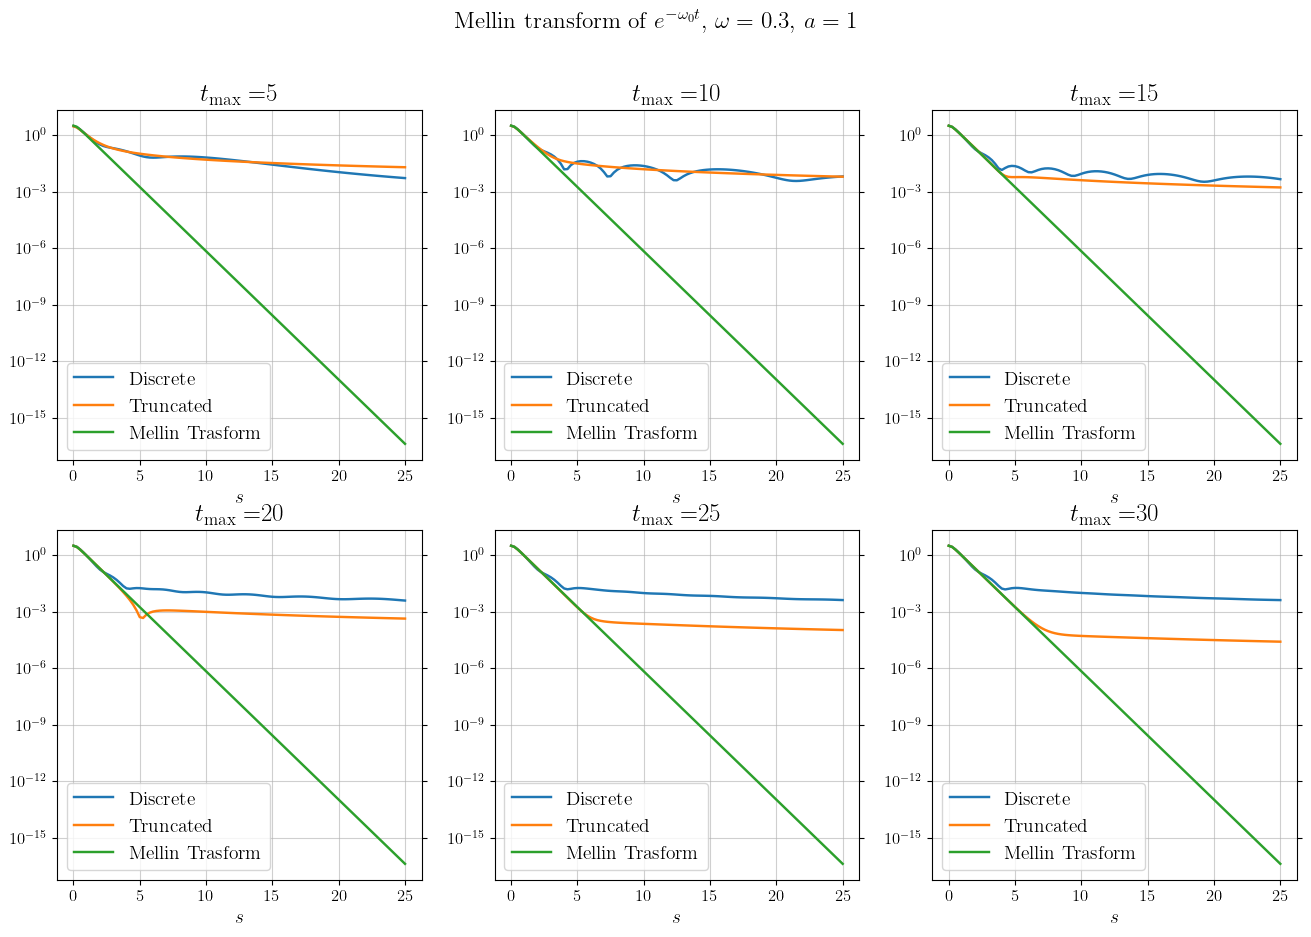

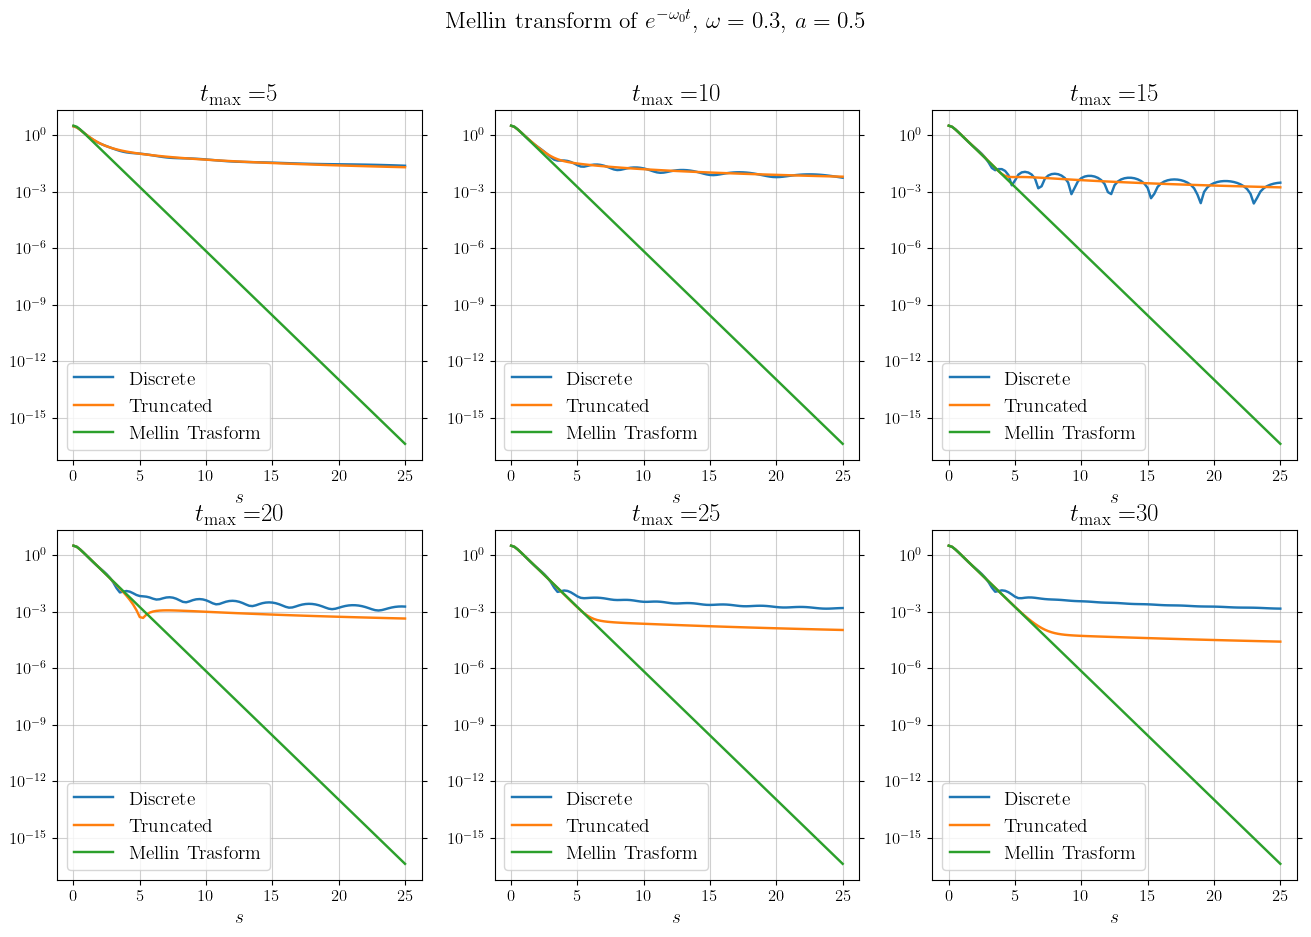

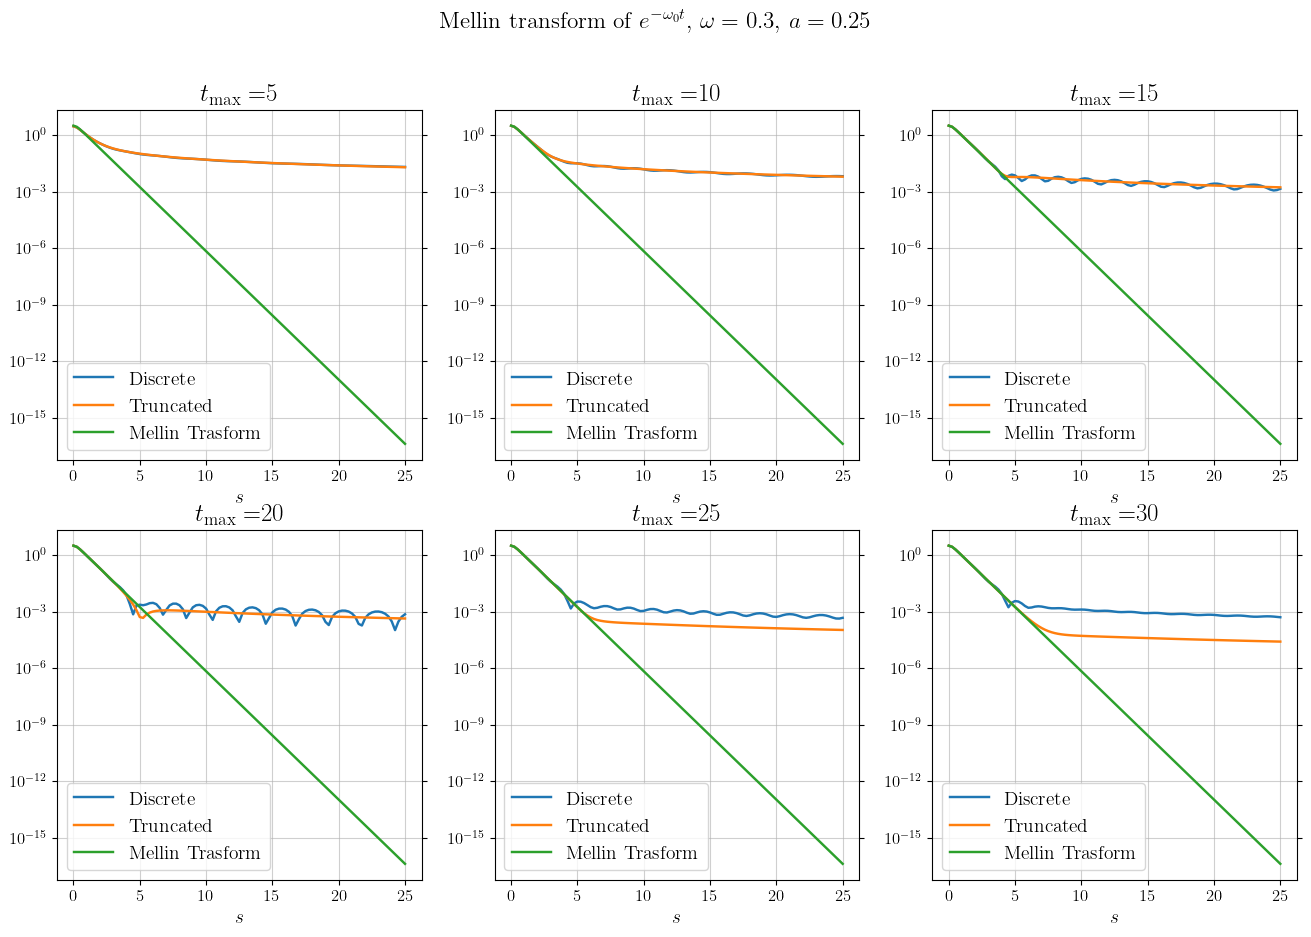

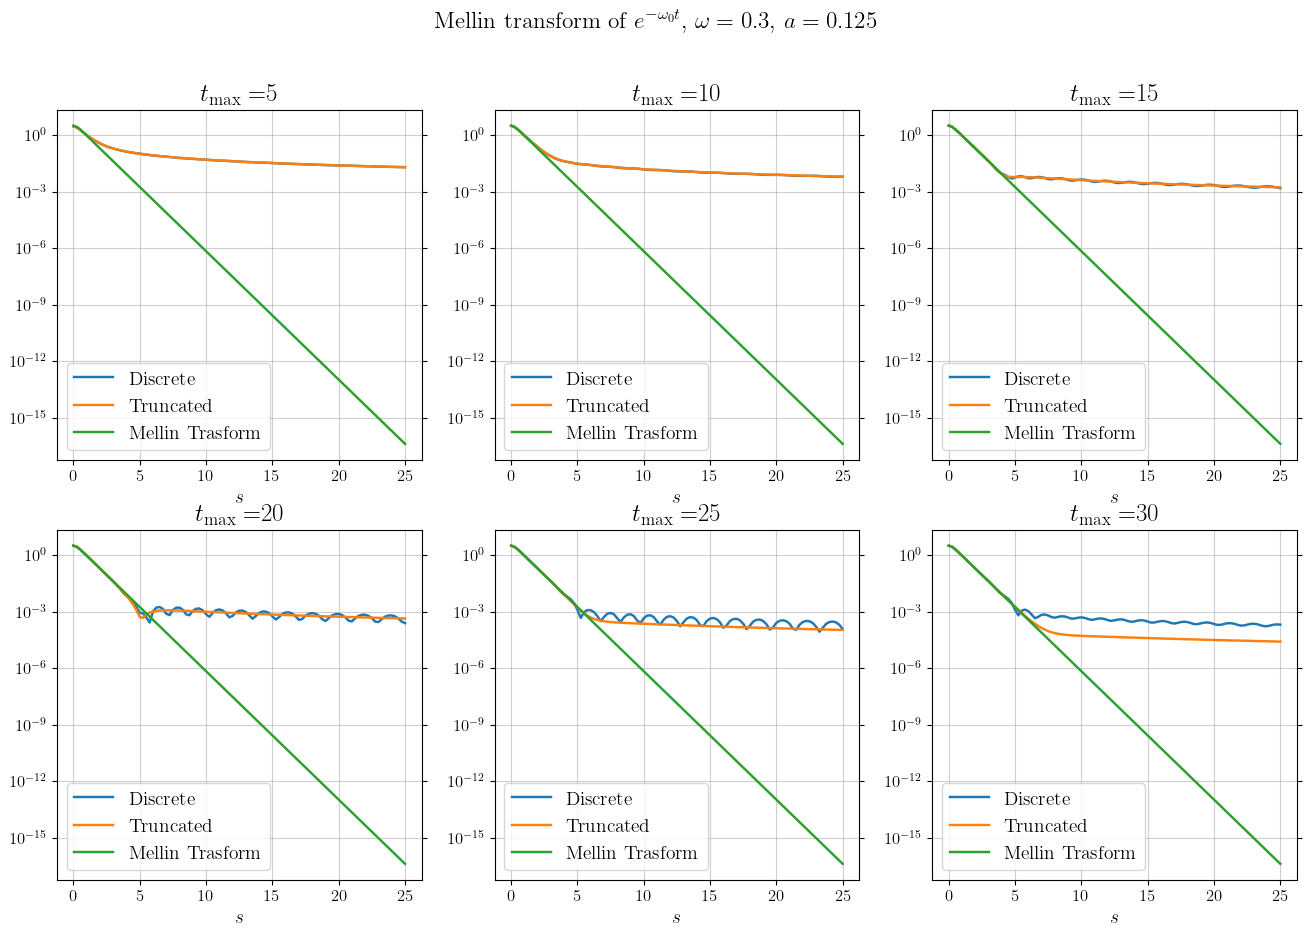

In [124]:
for ai in range(len(a)):
    plt.figure(figsize=[16, 10])
    for ti in range(len(t_max_corr)):
        plt.subplot(2, 3, ti+1)
        plt.plot(s, mel_discr[ai, ti], label = "Discrete")
        plt.plot(s, mel_trunc[ti], label = "Truncated")
        plt.plot(s, mel_cont, label = "Mellin Trasform")
        plt.xlabel(r"$s$")
        plt.title(r"$t_\mathrm{max} = $" + r"{}".format(t_max_corr[ti]))
        plt.semilogy()
        plt.legend()
    plt.suptitle(r"Mellin transform of $e^{-\omega_0 t}$, " + r"$\omega = {}$, $a = {}$".format(w0, a[ai]))
    plt.show()